In [5]:

import soundfile as sf
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import soundfile as sf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Visualizing Single Audio

In [10]:
song_file_name = '/Users/anjola/Desktop/Personal Projects/blues.00020.wav'

y,sr = librosa.load(song_file_name, sr=44100)
plt.figure(figsize =(14,5))
librosa.display.waveshow(y,sr=sr)

/var/folders/h0/lbhmvq590tzcg50vybbwpd8m0000gn/T/ipykernel_5618/3769885819.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y,sr = librosa.load(song_file_name, sr=44100)
/Users/anjola/Desktop/Personal Projects/Music genre classifier/tf-env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/anjola/Desktop/Personal Projects/blues.00020.wav'

This is the visualisation of this entire audio. We can also play this sound.

In [ ]:
from IPython.display import Audio
Audio(data= y, rate = sr)


In [ ]:
# jazz_song_name = '/Users/anjola/Desktop/Personal Projects/jazz.00005.wav'

# y,sr = librosa.load(jazz_song_name, sr = 44100)
# plt.figure(figsize=(14,5))
# librosa.display.waveshow(y,sr=sr)
# Audio(data = y, rate = sr)

Doing a visualisation on chunks of Audio


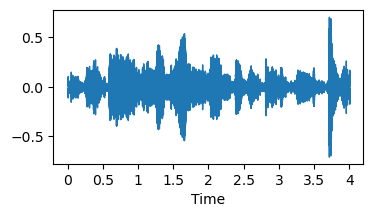

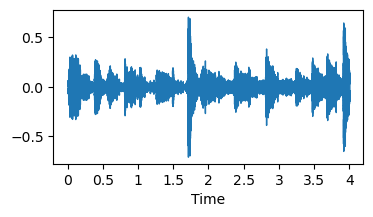

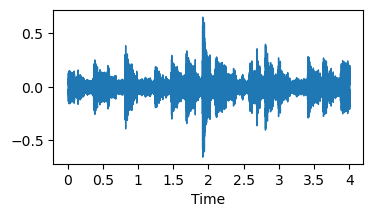

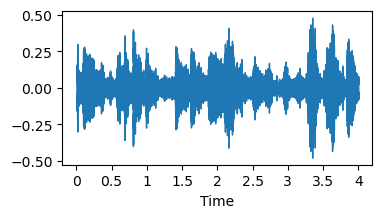

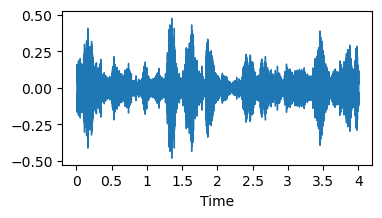

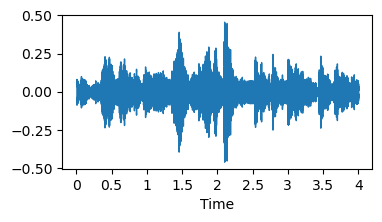

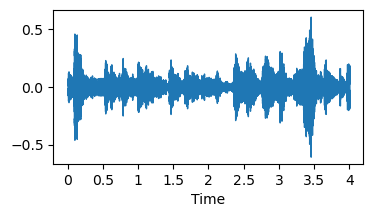

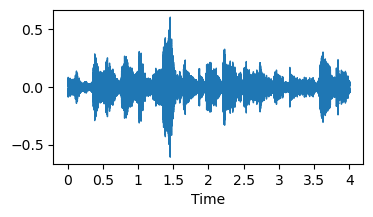

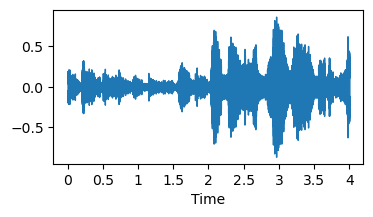

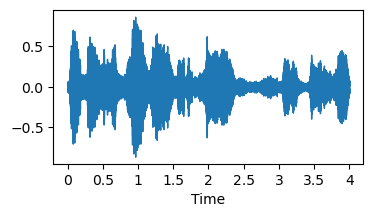

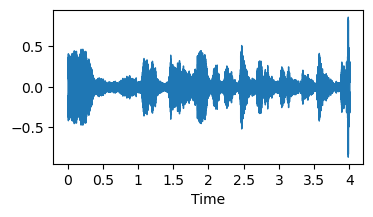

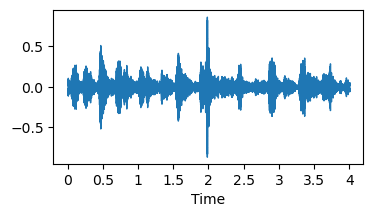

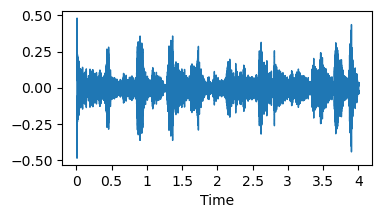

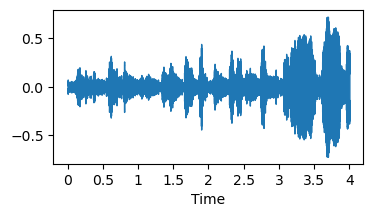

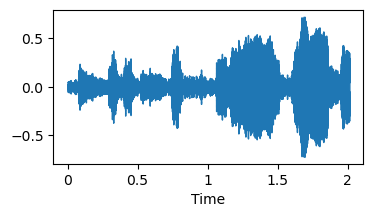

In [ ]:
audio_path = '/Users/anjola/Desktop/Personal Projects/blues.00020.wav'
y, sr = librosa.load(audio_path,sr =44100)# setting sr to none This means we want to keep the original sample rate
#Define the duration of each chunk and overlap
# Here if we are doing a 4 second chunk we want a 2 second overlap so that we can maintain information about the previous chunk.
#This will help our model to understand that each new chunk is a continuation of the previous one.


chunk_time = 4
overlap_time = 2

#Convert Duration to Sample
chunk_sample = chunk_time*sr
overlap_samples = overlap_time * sr


#We need to calculate how many number of chunks exist within this 30 second audio
total_chunk_num = int(np.ceil((len(y)-chunk_sample)/(chunk_sample-overlap_samples)))+1

#iterate over each chunk
for i in range(total_chunk_num):
    #Calculate start and end indices of the chunk
    start = i*(chunk_sample-overlap_samples)
    end = start+chunk_sample
    #extract chunk audio
    chunk = y[start:end]
    plt.figure(figsize = (4,2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()



Melspectrogram Visualisation

In [ ]:
#Here we plot the melspectrogram of the entire audio
def plot_melspectrogram(y,sr):
    #Compute Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)

    #Convert to decibels(log scale)
    spectrogram_decibel = librosa.power_to_db(spectrogram, ref= np.max)

    #Visualise spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_decibel, sr = sr, x_axis='time', y_axis = 'mel')
    plt.colorbar(format = '%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()





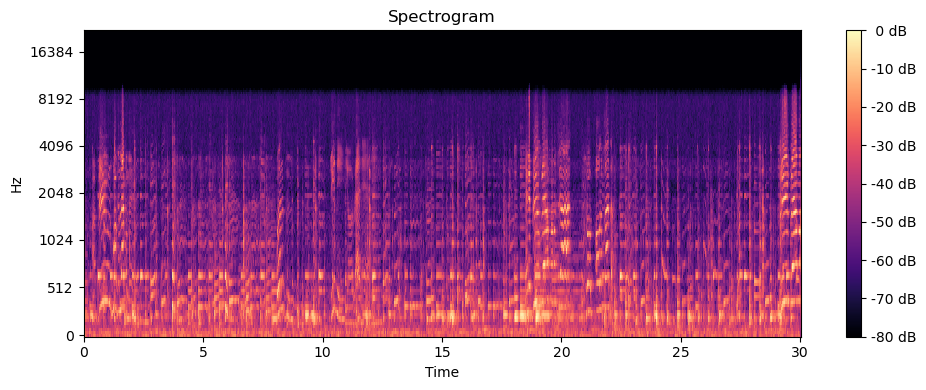

In [ ]:
song_file_name = '/Users/anjola/Desktop/Personal Projects/blues.00020.wav'

x,sr = librosa.load(song_file_name, sr=44100)

plot_melspectrogram(y, sr)


In [ ]:
def plot_melspectrogram_chunks(y,sr):
    #Define the duration of each chunk and overlap
# Here if we are doing a 4 second chunk we want a 2 second overlap so that we can maintain information about the previous chunk.
#This will help our model to understand that each new chunk is a continuation of the previous one.


    chunk_time = 4
    overlap_time = 2

    #Convert Duration to Sample
    chunk_sample = chunk_time*sr
    overlap_samples = overlap_time * sr


#We need to calculate how many number of chunks exist within this 30 second audio
    total_chunk_num = int(np.ceil((len(y)-chunk_sample)/(chunk_sample-overlap_samples)))+1

#iterate over each chunk
    for i in range(total_chunk_num):
    #Calculate start and end indices of the chunk
        start = i*(chunk_sample-overlap_samples)
        end = start+chunk_sample
    #extract chunk audio
        chunk = y[start:end]
        spectrogram = librosa.feature.melspectrogram(y=chunk, sr= sr)
        print(spectrogram.shape)
        spectrogram_decibel =librosa.power_to_db(spectrogram, ref= np.max)
        #Visualise the spectrogram
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_decibel, sr = sr, x_axis='time', y_axis = 'mel')
        plt.colorbar(format = '%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()
        plt.show()

    

(128, 345)


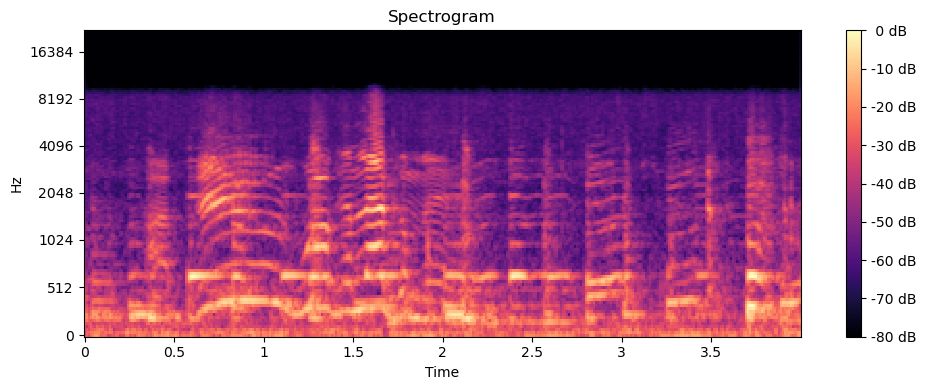

(128, 345)


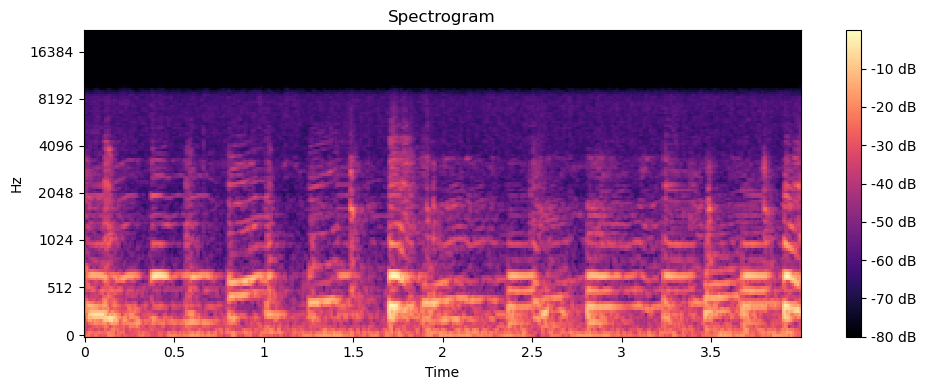

(128, 345)


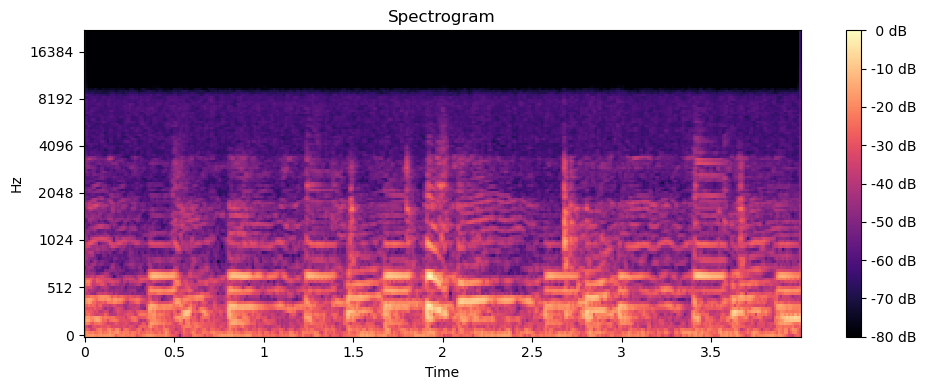

(128, 345)


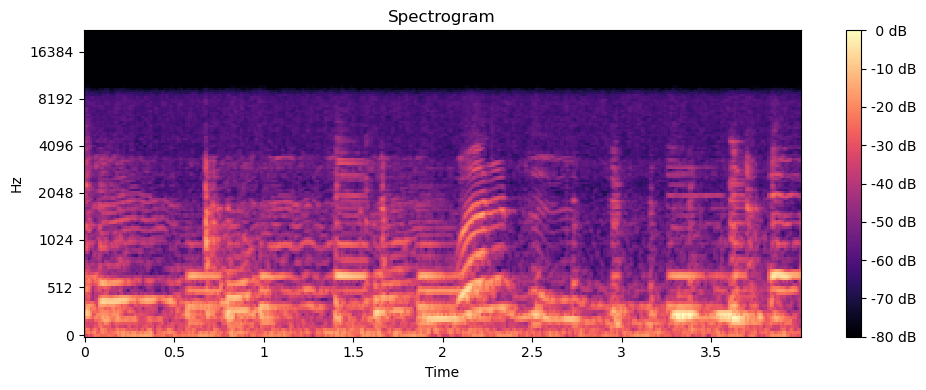

(128, 345)


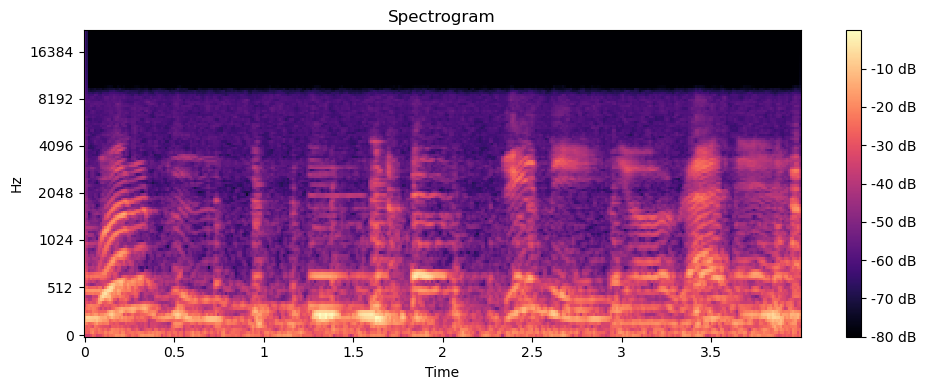

(128, 345)


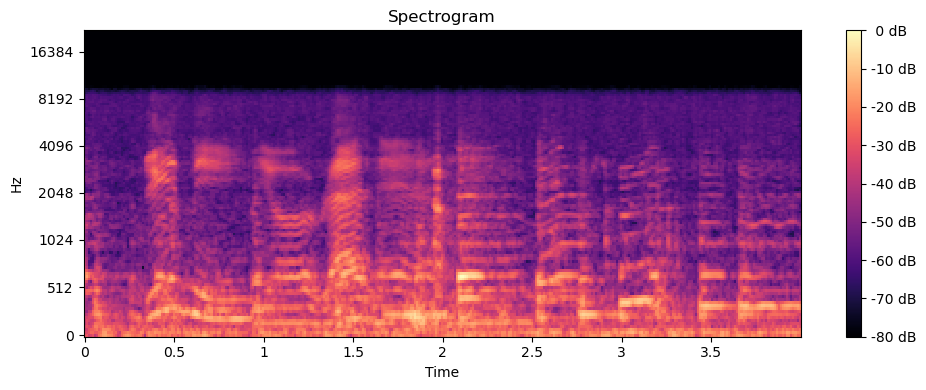

(128, 345)


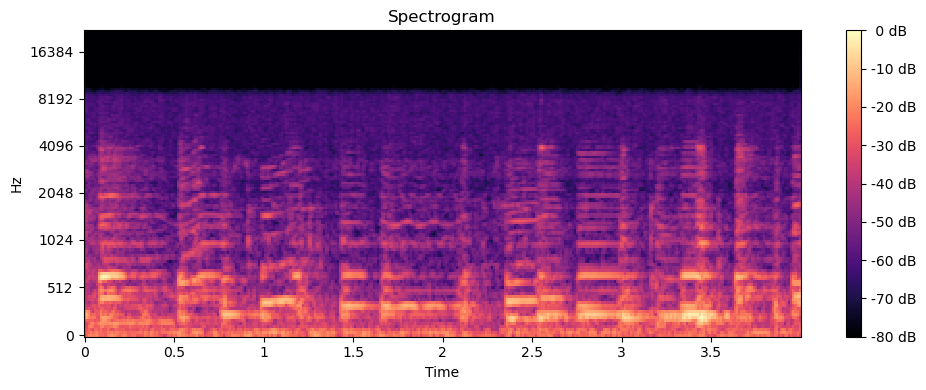

(128, 345)


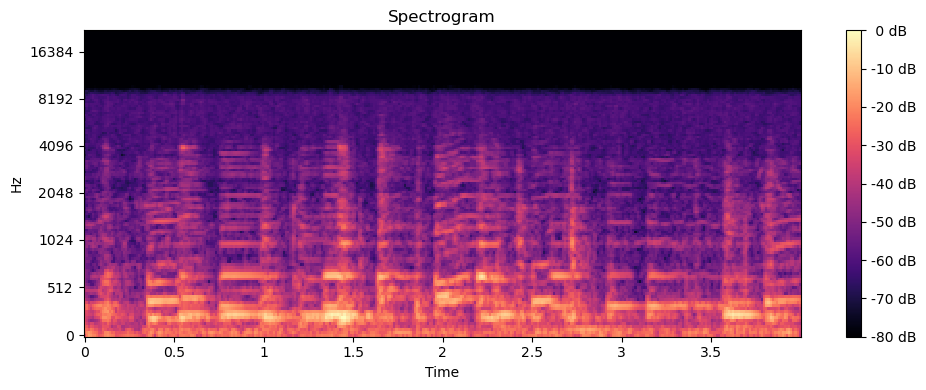

(128, 345)


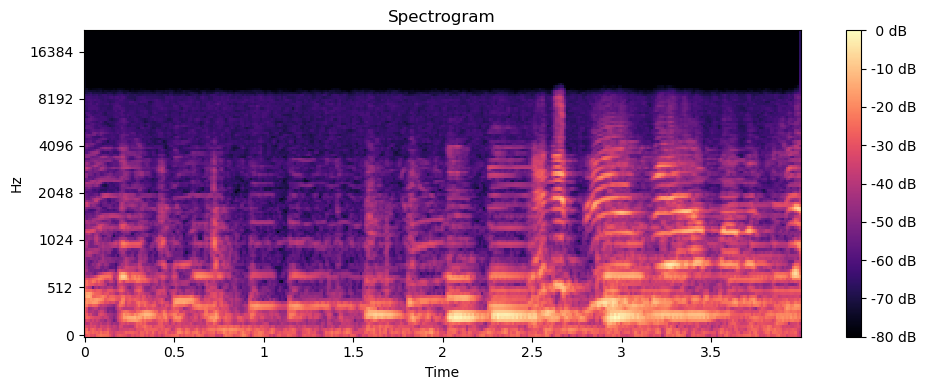

(128, 345)


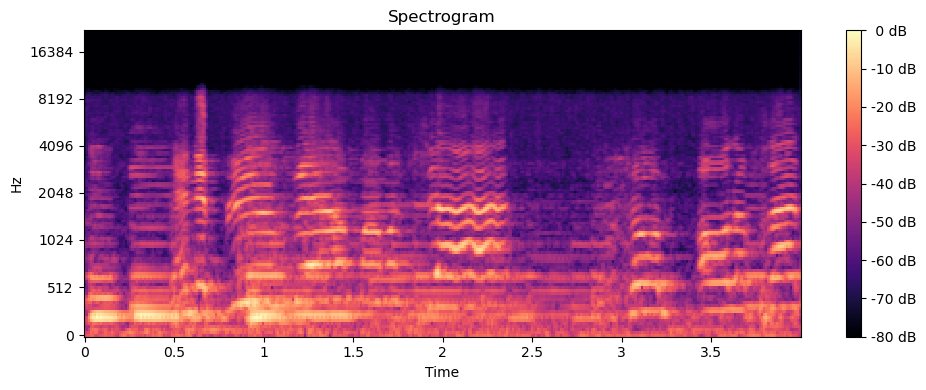

(128, 345)


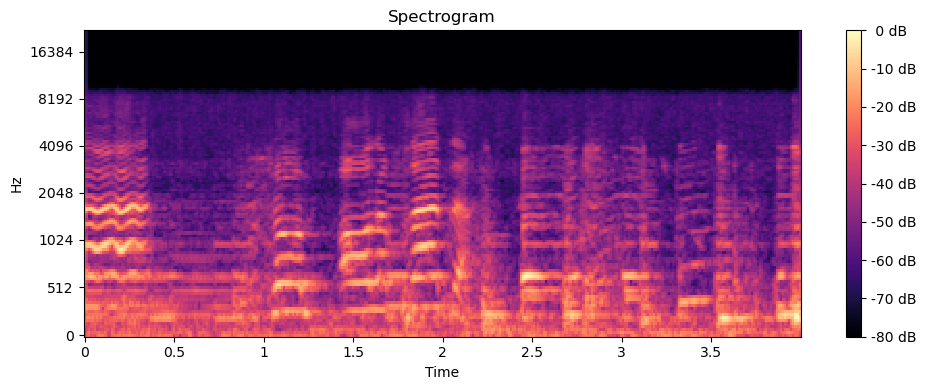

(128, 345)


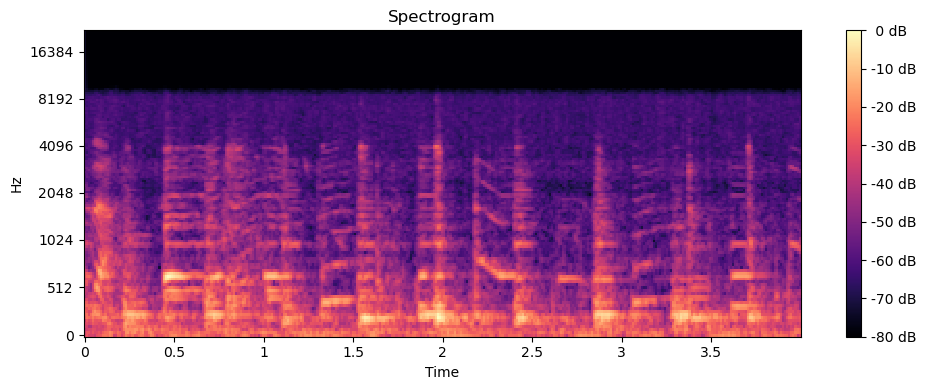

(128, 345)


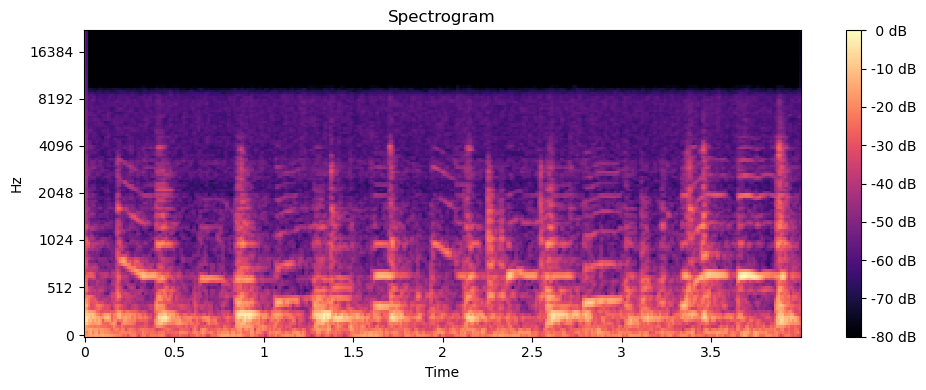

(128, 345)


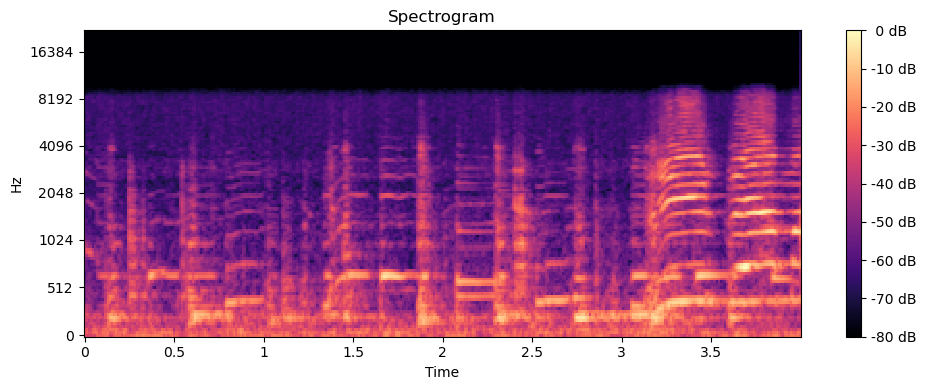

(128, 174)


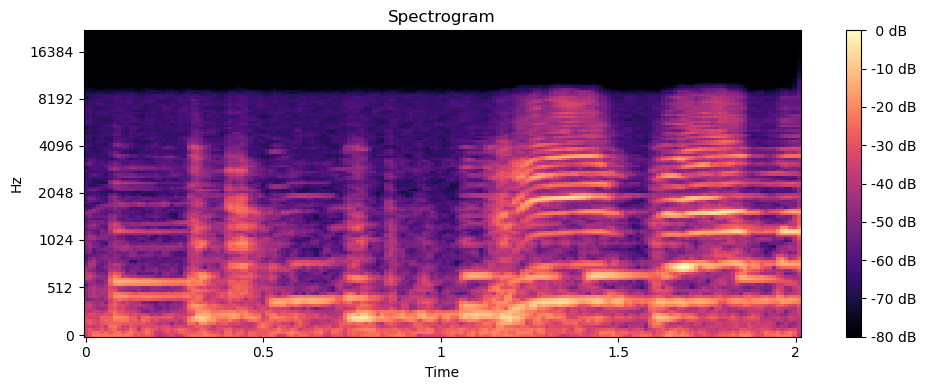

In [ ]:
song_file_name = '/Users/anjola/Desktop/Personal Projects/blues.00020.wav'

x,sr = librosa.load(song_file_name, sr=44100)
plot_melspectrogram_chunks(y,sr)

Data Preprocessing- Final

In [7]:
#define folder structure
directory = "./genres_original"
#List of Genres
genre_list =['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']




In [11]:
from tensorflow.image import resize
#Load and preprocess audio data
def load_and_preprocess_data(directory,genre_list,target_shape=(150,150)):
    # we will do feature extraction and append the information to the data list and their corresponding labels.
    data = []
    label = []
    skipped_files =[]#files that could not be processed

    for i_class,class_name in enumerate(genre_list):
        class_directory= os.path.join(directory,class_name)
        print(f"Processing-- {class_name}")
        #gives us the list of files in directory that end with 'wav'
        wav_files = [f for f in os.listdir(class_directory)if f.endswith('.wav')]
        print(f"Found {len(wav_files)}.wav files in {class_name}")
        for filename in wav_files:
            file_path = os.path.join(class_directory,filename)
            try:
               #Try to load the audio file
                audio_data,sample_rate = librosa.load(file_path,sr=None)
                if len(audio_data)==0:
                    print(f"Warning: Empty audio filename{filename},skipping...")
                    skipped_files.append(file_path)
                    continue

                #Performing preprocessing
                    #Define the duration of each chunk and overlap
                    # Here if we are doing a 6 second chunk we want a 3 second overlap so that we can maintain information about the previous chunk.
                    #This will help our model to understand that each new chunk is a continuation of the previous one.


                chunk_time = 6
                overlap_time = 3

                #Convert Duration to Sample
                chunk_sample = chunk_time*sample_rate
                overlap_samples = overlap_time * sample_rate


            #We need to calculate how many number of chunks exist within this 30 second audio
                total_chunk_num = int(np.ceil((len(audio_data)-chunk_sample)/(chunk_sample-overlap_samples)))+1

            #iterate over each chunk
                for i in range(total_chunk_num):
                #Calculate start and end indices of the chunk
                    start = i*(chunk_sample-overlap_samples)
                    end = start+chunk_sample
                #extract chunk audio
                    chunk = audio_data[start:end]

                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr= sample_rate)

                    #Resize matrix based on provided target shape.
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    label.append(i_class)
            except Exception as e:
                print(f"Error loading{filename}:{e}")
                skipped_files.append(file_path)
                continue
    #Return values
    return np.array(data),np.array(label)



In [9]:
data,labels = load_and_preprocess_data(directory,genre_list)

Processing-- blues
Found 100.wav files in blues
Processing-- classical
Found 100.wav files in classical
Processing-- country
Found 100.wav files in country
Processing-- disco
Found 100.wav files in disco
Processing-- hiphop
Found 100.wav files in hiphop
Processing-- jazz
Found 100.wav files in jazz


/var/folders/h0/lbhmvq590tzcg50vybbwpd8m0000gn/T/ipykernel_5618/1793047491.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data,sample_rate = librosa.load(file_path,sr=None)
/Users/anjola/Desktop/Personal Projects/Music genre classifier/tf-env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loadingjazz.00054.wav:
Processing-- metal
Found 100.wav files in metal
Processing-- pop
Found 100.wav files in pop
Processing-- reggae
Found 100.wav files in reggae
Processing-- rock
Found 100.wav files in rock


In [ ]:
data.shape

(9980, 150, 150, 1)

In [ ]:
labels.shape

(9980,)

In [ ]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes=len(genre_list))#Converting labels to one hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
labels.shape

(9980, 10)

splitting data into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data, labels, test_size=0.2, random_state = 29)

In [ ]:
X_train.shape

(7984, 150, 150, 1)

In [ ]:
Y_train.shape

(7984, 10)

Building Model

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
X_train[0].shape

(150, 150, 1)

In [ ]:
#adding the layers for the Convolutional neural network
model.add(Conv2D(filters =32,kernel_size =3,padding ='same',activation ='relu',input_shape=X_train[0].shape))#Input layer
model.add(Conv2D(filters =32,kernel_size =3,activation ='relu'))#second layer
model.add(MaxPool2D(pool_size =2,strides = 2))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.add(Conv2D(filters =64,kernel_size =3,padding ='same',activation ='relu'))
model.add(Conv2D(filters =64,kernel_size =3,activation ='relu'))
model.add(MaxPool2D(pool_size =2,strides = 2))

In [ ]:
model.add(Conv2D(filters =128,kernel_size =3,padding ='same',activation ='relu'))
model.add(Conv2D(filters =128,kernel_size =3,activation ='relu'))
model.add(MaxPool2D(pool_size =2,strides = 2))


In [ ]:
model.add(Dropout(0.3))

In [ ]:
model.add(Conv2D(filters =256,kernel_size =3,padding ='same',activation ='relu'))
model.add(Conv2D(filters =256,kernel_size =3,activation ='relu'))
model.add(MaxPool2D(pool_size =2,strides = 2))


In [ ]:
model.add(Conv2D(filters =512,kernel_size =3,padding ='same',activation ='relu'))
model.add(Conv2D(filters =512,kernel_size =3,activation ='relu'))
model.add(MaxPool2D(pool_size =2,strides = 2))


In [ ]:
model.add(Dropout(0.3))

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dense(units=1200,activation ='relu'))

In [ ]:
model.add(Dropout(0.45))


In [ ]:
#output layer
model.add(Dense(units = len(genre_list),activation = 'softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the model
model.compile(optimizer= Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
##Training Model
training_history = model.fit(X_train,Y_train,epochs =30,batch_size =32,validation_data =(X_test,Y_test))

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 866ms/step - accuracy: 0.1748 - loss: 2.1930 - val_accuracy: 0.3282 - val_loss: 1.8037
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 210s 841ms/step - accuracy: 0.3336 - loss: 1.7800 - val_accuracy: 0.4805 - val_loss: 1.4585
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 842ms/step - accuracy: 0.5095 - loss: 1.3950 - val_accuracy: 0.5992 - val_loss: 1.1493
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 842ms/step - accuracy: 0.6000 - loss: 1.1362 - val_accuracy: 0.6393 - val_loss: 1.0312
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 239s 957ms/step - accuracy: 0.6498 - loss: 1.0168 - val_accuracy: 0.6834 - val_loss: 0.9527
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 232s 926ms/step - accuracy: 0.7023 - loss: 0.8488 - val_accuracy: 0.7089 - val_loss: 0.8722
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 238s 953ms/step - accuracy: 0.7371 - loss: 0.7696 - val_accuracy: 0.6733 - val_loss: 0.9287
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 239s 956ms/step - accuracy: 0.7717 -

In [ ]:
model.save("Trained_model.keras")

In [ ]:
training_history.history

{'accuracy': [0.22444890439510345,
  0.38502004742622375,
  0.5270541310310364,
  0.6093437075614929,
  0.6615731716156006,
  0.7128006219863892,
  0.7433617115020752,
  0.7809368968009949,
  0.804734468460083,
  0.8331663608551025,
  0.851077139377594,
  0.8718687295913696,
  0.8936623334884644,
  0.9009268283843994,
  0.9091933965682983,
  0.9205911755561829,
  0.9332414865493774,
  0.937750518321991,
  0.9436372518539429,
  0.9551603198051453,
  0.9597945809364319,
  0.960796594619751,
  0.9693136215209961,
  0.9624248743057251,
  0.969188392162323,
  0.9726954102516174,
  0.9745741486549377,
  0.9713176488876343,
  0.9823396801948547,
  0.9785821437835693],
 'loss': [2.0813636779785156,
  1.679019570350647,
  1.339590311050415,
  1.1142628192901611,
  0.9835262894630432,
  0.8314092755317688,
  0.7505533695220947,
  0.651422917842865,
  0.5742045044898987,
  0.5022374987602234,
  0.43771427869796753,
  0.3902052342891693,
  0.31891489028930664,
  0.29699504375457764,
  0.2690917253

In [ ]:
#Recording History in Json
import json
with open('training_hist.json','w') as f:
    json.dump(training_history.history,f)

Perform Model evaluation

In [ ]:
X_train

array([[[[1.15554559e+00],
         [1.19314158e+00],
         [1.21285272e+00],
         ...,
         [5.64929187e-01],
         [2.87710093e-02],
         [1.54673472e-01]],

        [[2.82387853e+00],
         [2.63953662e+00],
         [5.06424665e+00],
         ...,
         [3.70421958e+00],
         [1.45202726e-01],
         [1.15010045e-01]],

        [[3.50551343e+00],
         [4.91146088e+00],
         [2.81089306e+01],
         ...,
         [3.57413816e+00],
         [3.62631649e-01],
         [2.55054384e-01]],

        ...,

        [[1.47997038e-04],
         [1.93225220e-02],
         [7.57419407e-01],
         ...,
         [8.81161019e-02],
         [2.43501849e-02],
         [2.52389535e-03]],

        [[1.92299296e-04],
         [3.00158095e-02],
         [1.03541338e+00],
         ...,
         [1.25240296e-01],
         [3.80828939e-02],
         [2.86397617e-03]],

        [[2.44161871e-04],
         [2.29376517e-02],
         [7.34509706e-01],
         ...,
 

In [ ]:
#Reloading Model Variable
model = tf.keras.models.load_model("Trained_model.keras")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,547,376 (82.20 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,364,918 (54.80 MB)

In [ ]:
#Reload training history for model evaluation
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)
    

In [ ]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
#Model evaluation on training set
train_loss,train_accuracy=model.evaluate(X_train,Y_train)

250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.9924 - loss: 0.0243


In [ ]:
train_loss,train_accuracy

(0.02424321509897709, 0.9933617115020752)

In [ ]:
#model evaluation on validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.8966 - loss: 0.4258


In [ ]:
val_loss,val_accuracy

(0.4345146417617798, 0.8912825584411621)

Accuracy and Loss Visualisation

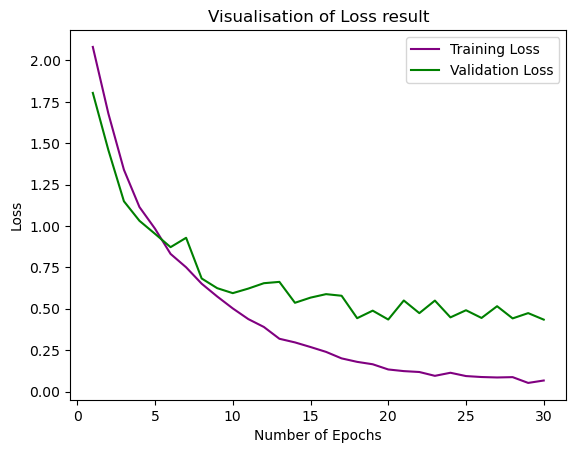

In [ ]:
#Visualisation of training loss
epochs = [i for i in range(1,31)]#This technique is called list comprehension
plt.plot(epochs,training_history_data['loss'],label= "Training Loss",color ="purple")
plt.plot(epochs,training_history_data['val_loss'],label = "Validation Loss",color = "green")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Visualisation of Loss result")
plt.legend()
plt.show()


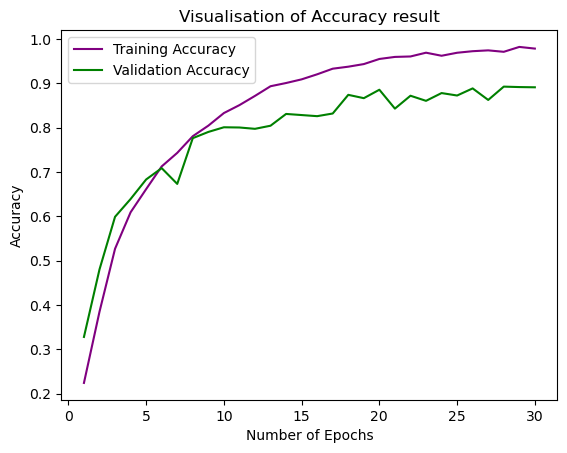

In [ ]:
#Visualisation of Accuracy
epochs = [i for i in range(1,31)]#This technique is called list comprehension
plt.plot(epochs,training_history_data['accuracy'],label= "Training Accuracy",color ="purple")
plt.plot(epochs,training_history_data['val_accuracy'],label = "Validation Accuracy",color = "green")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualisation of Accuracy result")
plt.legend()
plt.show()

## Precision, Recall, Confusion Matrix for Model evaluation Part 2

In [ ]:
X_test.shape

(1996, 150, 150, 1)

In [ ]:
y_pred = model.predict(X_test)
y_pred

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step


array([[7.1465176e-05, 3.3914183e-08, 1.7953283e-07, ..., 9.3011935e-05,
        3.4251195e-07, 2.3654003e-04],
       [4.3933756e-05, 1.7017607e-08, 9.9370444e-01, ..., 1.1547279e-05,
        1.4823006e-04, 6.0911085e-03],
       [1.2226260e-06, 9.9967676e-01, 1.4922964e-06, ..., 2.9483390e-05,
        3.1336231e-06, 1.0688854e-05],
       ...,
       [2.0465245e-07, 7.2359758e-09, 2.4847969e-07, ..., 1.9204410e-07,
        3.1633370e-08, 3.3805132e-05],
       [6.2961600e-09, 1.1740157e-12, 2.8584238e-10, ..., 8.3828300e-12,
        2.1898262e-12, 7.4460818e-06],
       [8.7991098e-10, 5.8198975e-13, 6.5370945e-11, ..., 2.5556835e-08,
        1.6863312e-09, 2.2204257e-07]], dtype=float32)

In [ ]:
y_pred.shape

(1996, 10)

In [ ]:
pred_categories = np.argmax(y_pred,axis=1)# Axis=1 means vertically iterate over each columns and extract the maximum index out of them.
pred_categories

array([3, 2, 1, ..., 6, 6, 3])

In [ ]:
Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
actual_categories = np.argmax(Y_test,axis=1)
actual_categories

array([3, 2, 1, ..., 6, 6, 3])

In [ ]:
genre_list


['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(actual_categories,pred_categories)


#Precision Recall F1score
print(classification_report(actual_categories,pred_categories,target_names=genre_list))

              precision    recall  f1-score   support

       blues       0.86      0.90      0.88       205
   classical       0.95      0.94      0.95       196
     country       0.84      0.90      0.87       200
       disco       0.89      0.89      0.89       187
      hiphop       0.90      0.89      0.90       203
        jazz       0.96      0.91      0.93       183
       metal       0.90      0.95      0.92       204
         pop       0.92      0.85      0.88       221
      reggae       0.92      0.88      0.90       194
        rock       0.80      0.82      0.81       203

    accuracy                           0.89      1996
   macro avg       0.89      0.89      0.89      1996
weighted avg       0.89      0.89      0.89      1996



### Visualise Confusion Matrix

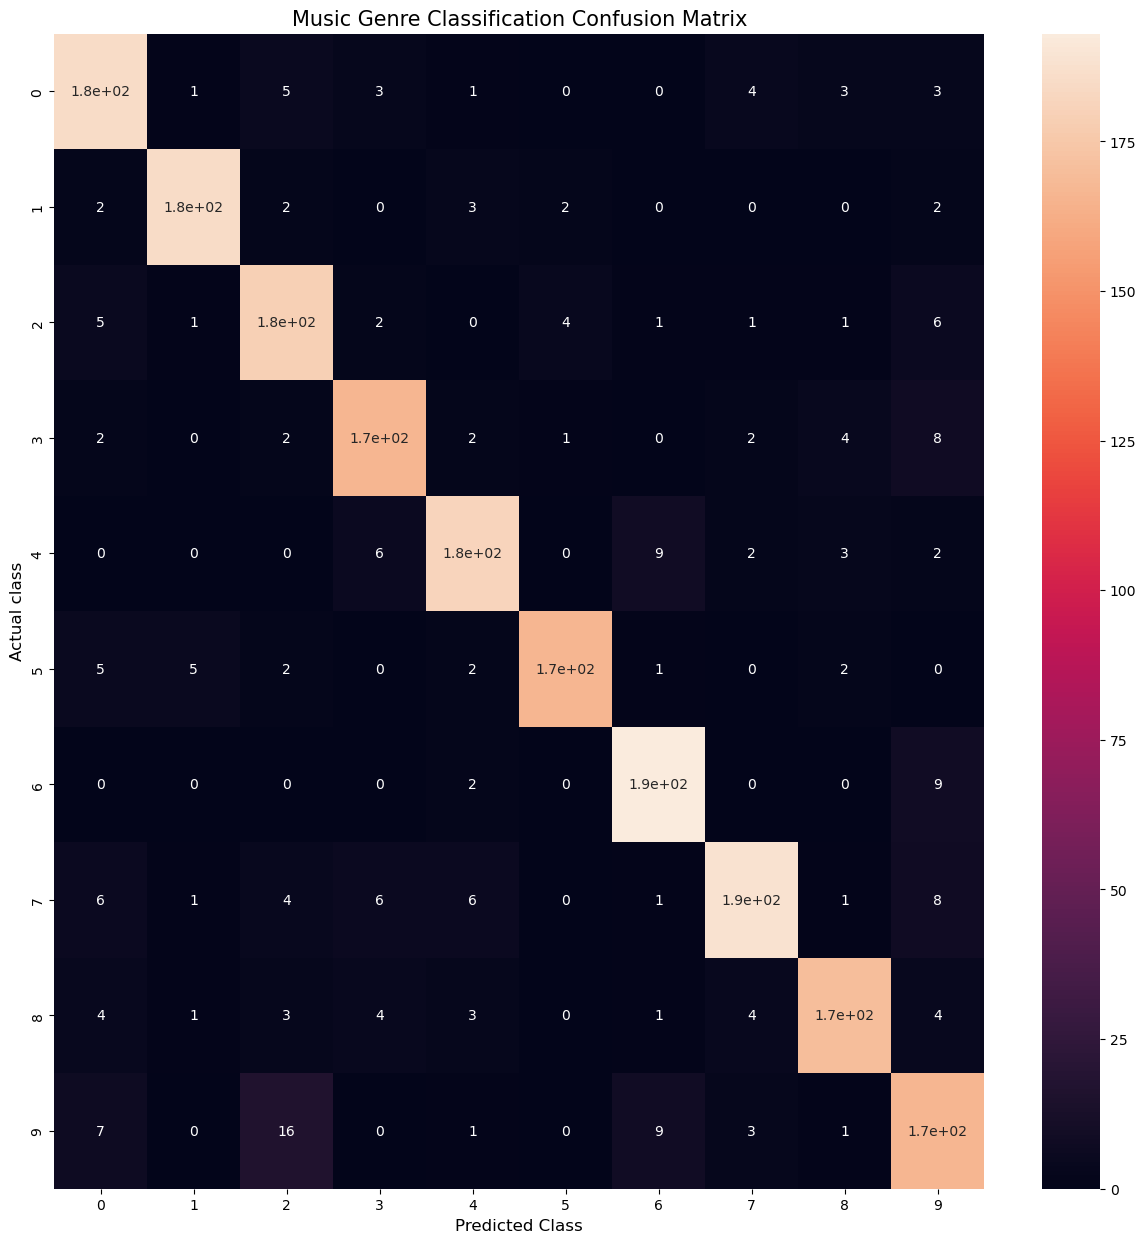

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot = True,annot_kws={"size":10 })
plt.xlabel("Predicted Class",fontsize=12)
plt.ylabel("Actual class",fontsize =12)
plt.title("Music Genre Classification Confusion Matrix",fontsize =15)
plt.show()
